# Problem 1: The Eight Schools

Students at eight schools each participated in a test-prep program. After examination, the average score improvement $ \Delta S$ for each school was recorded, along with the uncertainty on this measurement $ \sigma( \Delta S)$:

   + $ \Delta S$ = [28, 8, -3, 7, -1, 1, 18, 12]

   + $ \sigma( \Delta S$) = [15, 10, 16, 11, 9, 11, 10, 18]


a) Calculate the pooled mean improvement and uncertainty on the mean

b) Fit the data using a hierarchical modeling. Assuming the score improvements $\theta = \Delta S$ were drawn from a population that can be modeled as a Gaussian with mean $\mu$ and uncertainty $\sigma$.

* i. Draw your hyperparameters $\alpha = \{\mu, \sigma\}$ from a Gaussian and Half-Cauchy distribution, respectively
* ii. Test other choices of distributions for the hyper-priors and population. How sensitive are the results?

Sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ate_schools = {'school': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 'delta S' : [28, 8, -3, 7, -1, 1, 18, 12], 'sigma' : [15,10, 16, 11, 9, 11, 10, 18]}
df = pd.DataFrame(ate_schools)
df.head()

,school,delta S,sigma
0,A,28,15
1,B,8,10
2,C,-3,16
3,D,7,11
4,E,-1,9


Text(0.5, 0, 'School')

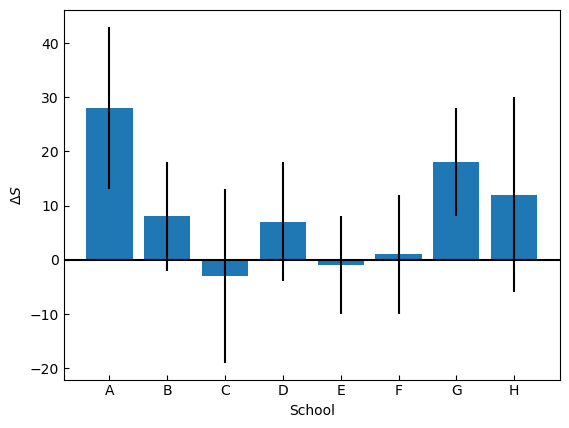

In [2]:
fig, ax = plt.subplots()
ax.bar(df['school'], df['delta S'], yerr = df['sigma'])
ax.tick_params(direction='in')
ax.axhline(0, c='k')
ax.set_ylabel(r'$\Delta S$')
ax.set_xlabel('School')

a)

In [3]:
# Part a) Calculate pooled mean and uncertainty
pooled_mean = np.mean(df['delta S'])
# Uncertainty on the pooled mean (assuming independent measurements)
pooled_uncertainty = np.sqrt(np.sum(df['sigma']**2)) / len(df)

print(f"Pooled mean: {pooled_mean:.2f}")
print(f"Uncertainty on pooled mean: {pooled_uncertainty:.2f}")

Pooled mean: 8.75
Uncertainty on pooled mean: 4.56


b)

$$\frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}},$$

In [4]:
np.random.standard_normal()

-0.47772598264911637

In [5]:
from scipy.stats import norm
from scipy.stats import halfcauchy

sample = norm.rvs(loc=10, scale=5)
print(sample)

half_cauchy_sample = halfcauchy.rvs(loc=0, scale=5)
print(half_cauchy_sample)

10.657431866414868
7.882963151155841


In [6]:
def lnprior(params):
    '''
    Calculate the log prior for the hierarchical model
    
    Parameters
    --------
    params : array-like, shape (10,)
        [theta_1, ..., theta_8, mu, tau] where:
        - theta_i are the school effects
        - mu is the population mean hyperparameter  
        - tau is the population scale hyperparameter
    
    Returns
    --------
    lnp : float
        the log-prior for this set of parameters
    '''
    theta = params[:8]  # school effects
    mu = params[8]      # population mean
    tau = params[9]     # population scale
    
    # Check bounds
    if tau <= 0:
        return -np.inf
    
    # Hyperprior on mu: Normal(0, 20)
    lnp_mu = norm.logpdf(mu, loc=0, scale=20)
    
    # Hyperprior on tau: Half-Cauchy(0, 5)
    lnp_tau = halfcauchy.logpdf(tau, loc=0, scale=5)
    
    # Prior on theta_i given hyperparameters: Normal(mu, tau)
    lnp_theta = np.sum(norm.logpdf(theta, loc=mu, scale=tau))
    
    return lnp_mu + lnp_tau + lnp_theta



In [7]:
def lnlikelihood(params, y, y_unc):
    '''
    Calculate the log likelihood for the hierarchical model
    
    Parameters
    ----------
    params : array-like, shape (10,)
        [theta_1, ..., theta_8, mu, tau] where theta_i are school effects
    y : array-like, shape (8,)
        Observed score improvements for each school
    y_unc : array-like, shape (8,)
        Uncertainties on observed score improvements
        
    Returns
    -------
    lnl : float
        The log-likelihood of the observations given the model parameters
    '''
    theta = params[:8]  # school effects
    
    # Likelihood: y_i ~ Normal(theta_i, sigma_i)
    # where sigma_i are the known measurement uncertainties
    lnl = np.sum(norm.logpdf(y, loc=theta, scale=y_unc))
    
    return lnl

In [8]:
def lnprob(params, y, y_unc):
    '''
    Calculate the log posterior probability (likelihood + prior)
    
    Parameters
    ----------
    params : array-like, shape (10,)
        [theta_1, ..., theta_8, mu, tau]
    y : array-like, shape (8,)
        Observed data
    y_unc : array-like, shape (8,) 
        Measurement uncertainties
        
    Returns
    -------
    lnp : float
        Log posterior probability
    '''
    lnp_prior = lnprior(params)
    
    if not np.isfinite(lnp_prior):
        return -np.inf
        
    lnp_likelihood = lnlikelihood(params, y, y_unc)
    
    return lnp_prior + lnp_likelihood


In [9]:
ndim, nwalkers = 10, 50
# Initialize walkers
# theta_i (school effects) around observed values
theta_init = np.random.normal(np.array(df['delta S']), 5, size=(nwalkers, 8))
# mu (population mean) around overall mean
mu_init = np.random.normal(np.mean(df['delta S']), 5, size=(nwalkers, 1))
# tau (population scale) as positive values
tau_init = np.random.exponential(10, size=(nwalkers, 1))

# Combine into initial positions
p0 = np.hstack([theta_init, mu_init, tau_init])

import emcee

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(np.array(df['delta S']), np.array(df['sigma'])))

print("Running MCMC...")
sampler.run_mcmc(p0, 1000, progress=True)
print("Done!")

You must install the tqdm library to use progress indicators with emcee


Running MCMC...
Done!
Done!


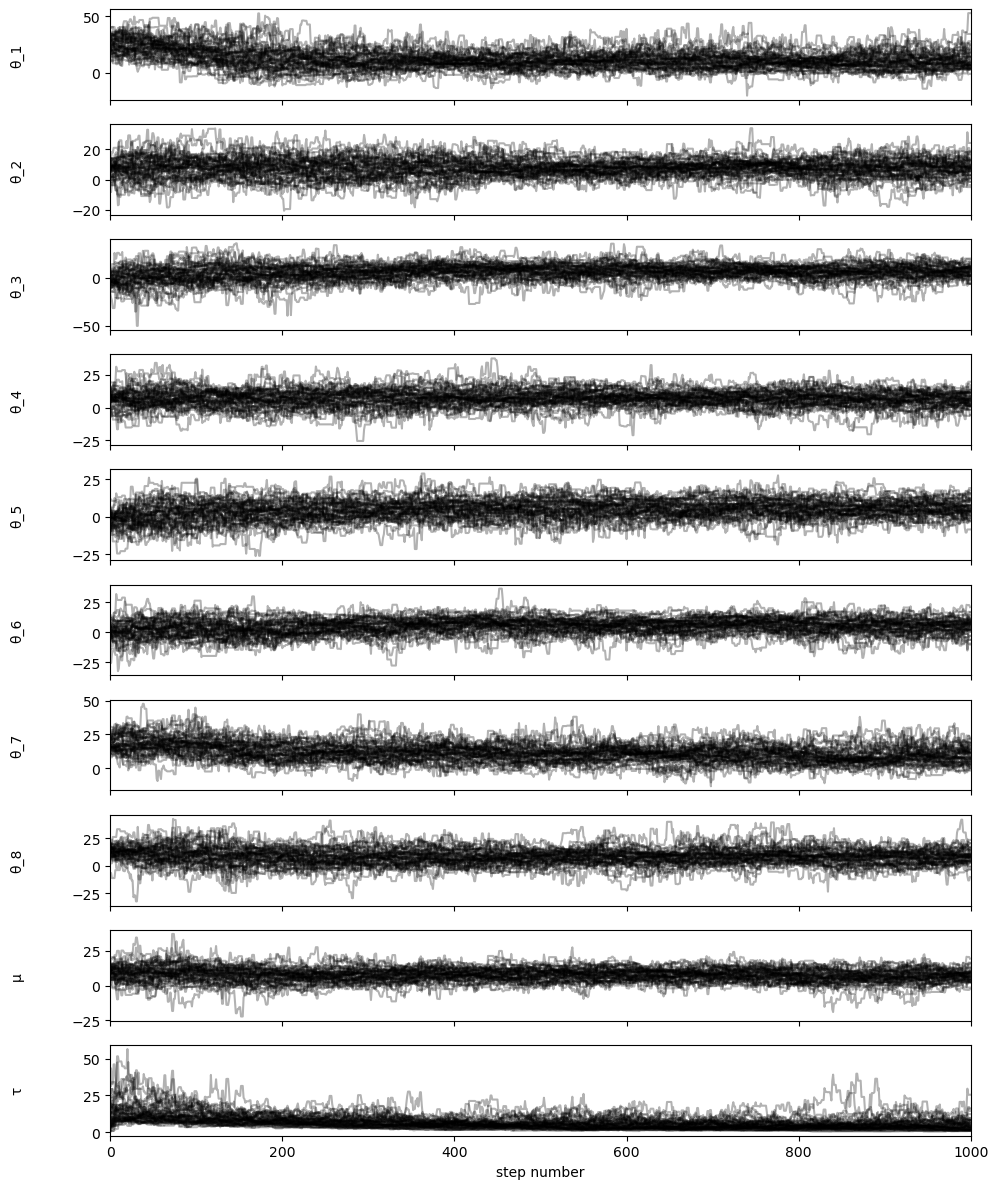

In [12]:
def plot_chains(ax, samples, i, labels):
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Plot chains for all parameters
fig, axes = plt.subplots(10, figsize=(10, 12), sharex=True)
samples = sampler.get_chain()
labels = [f"θ_{i+1}" for i in range(8)] + ["μ", "τ"]

for i in range(ndim):
    plot_chains(axes[i], samples, i, labels)

axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

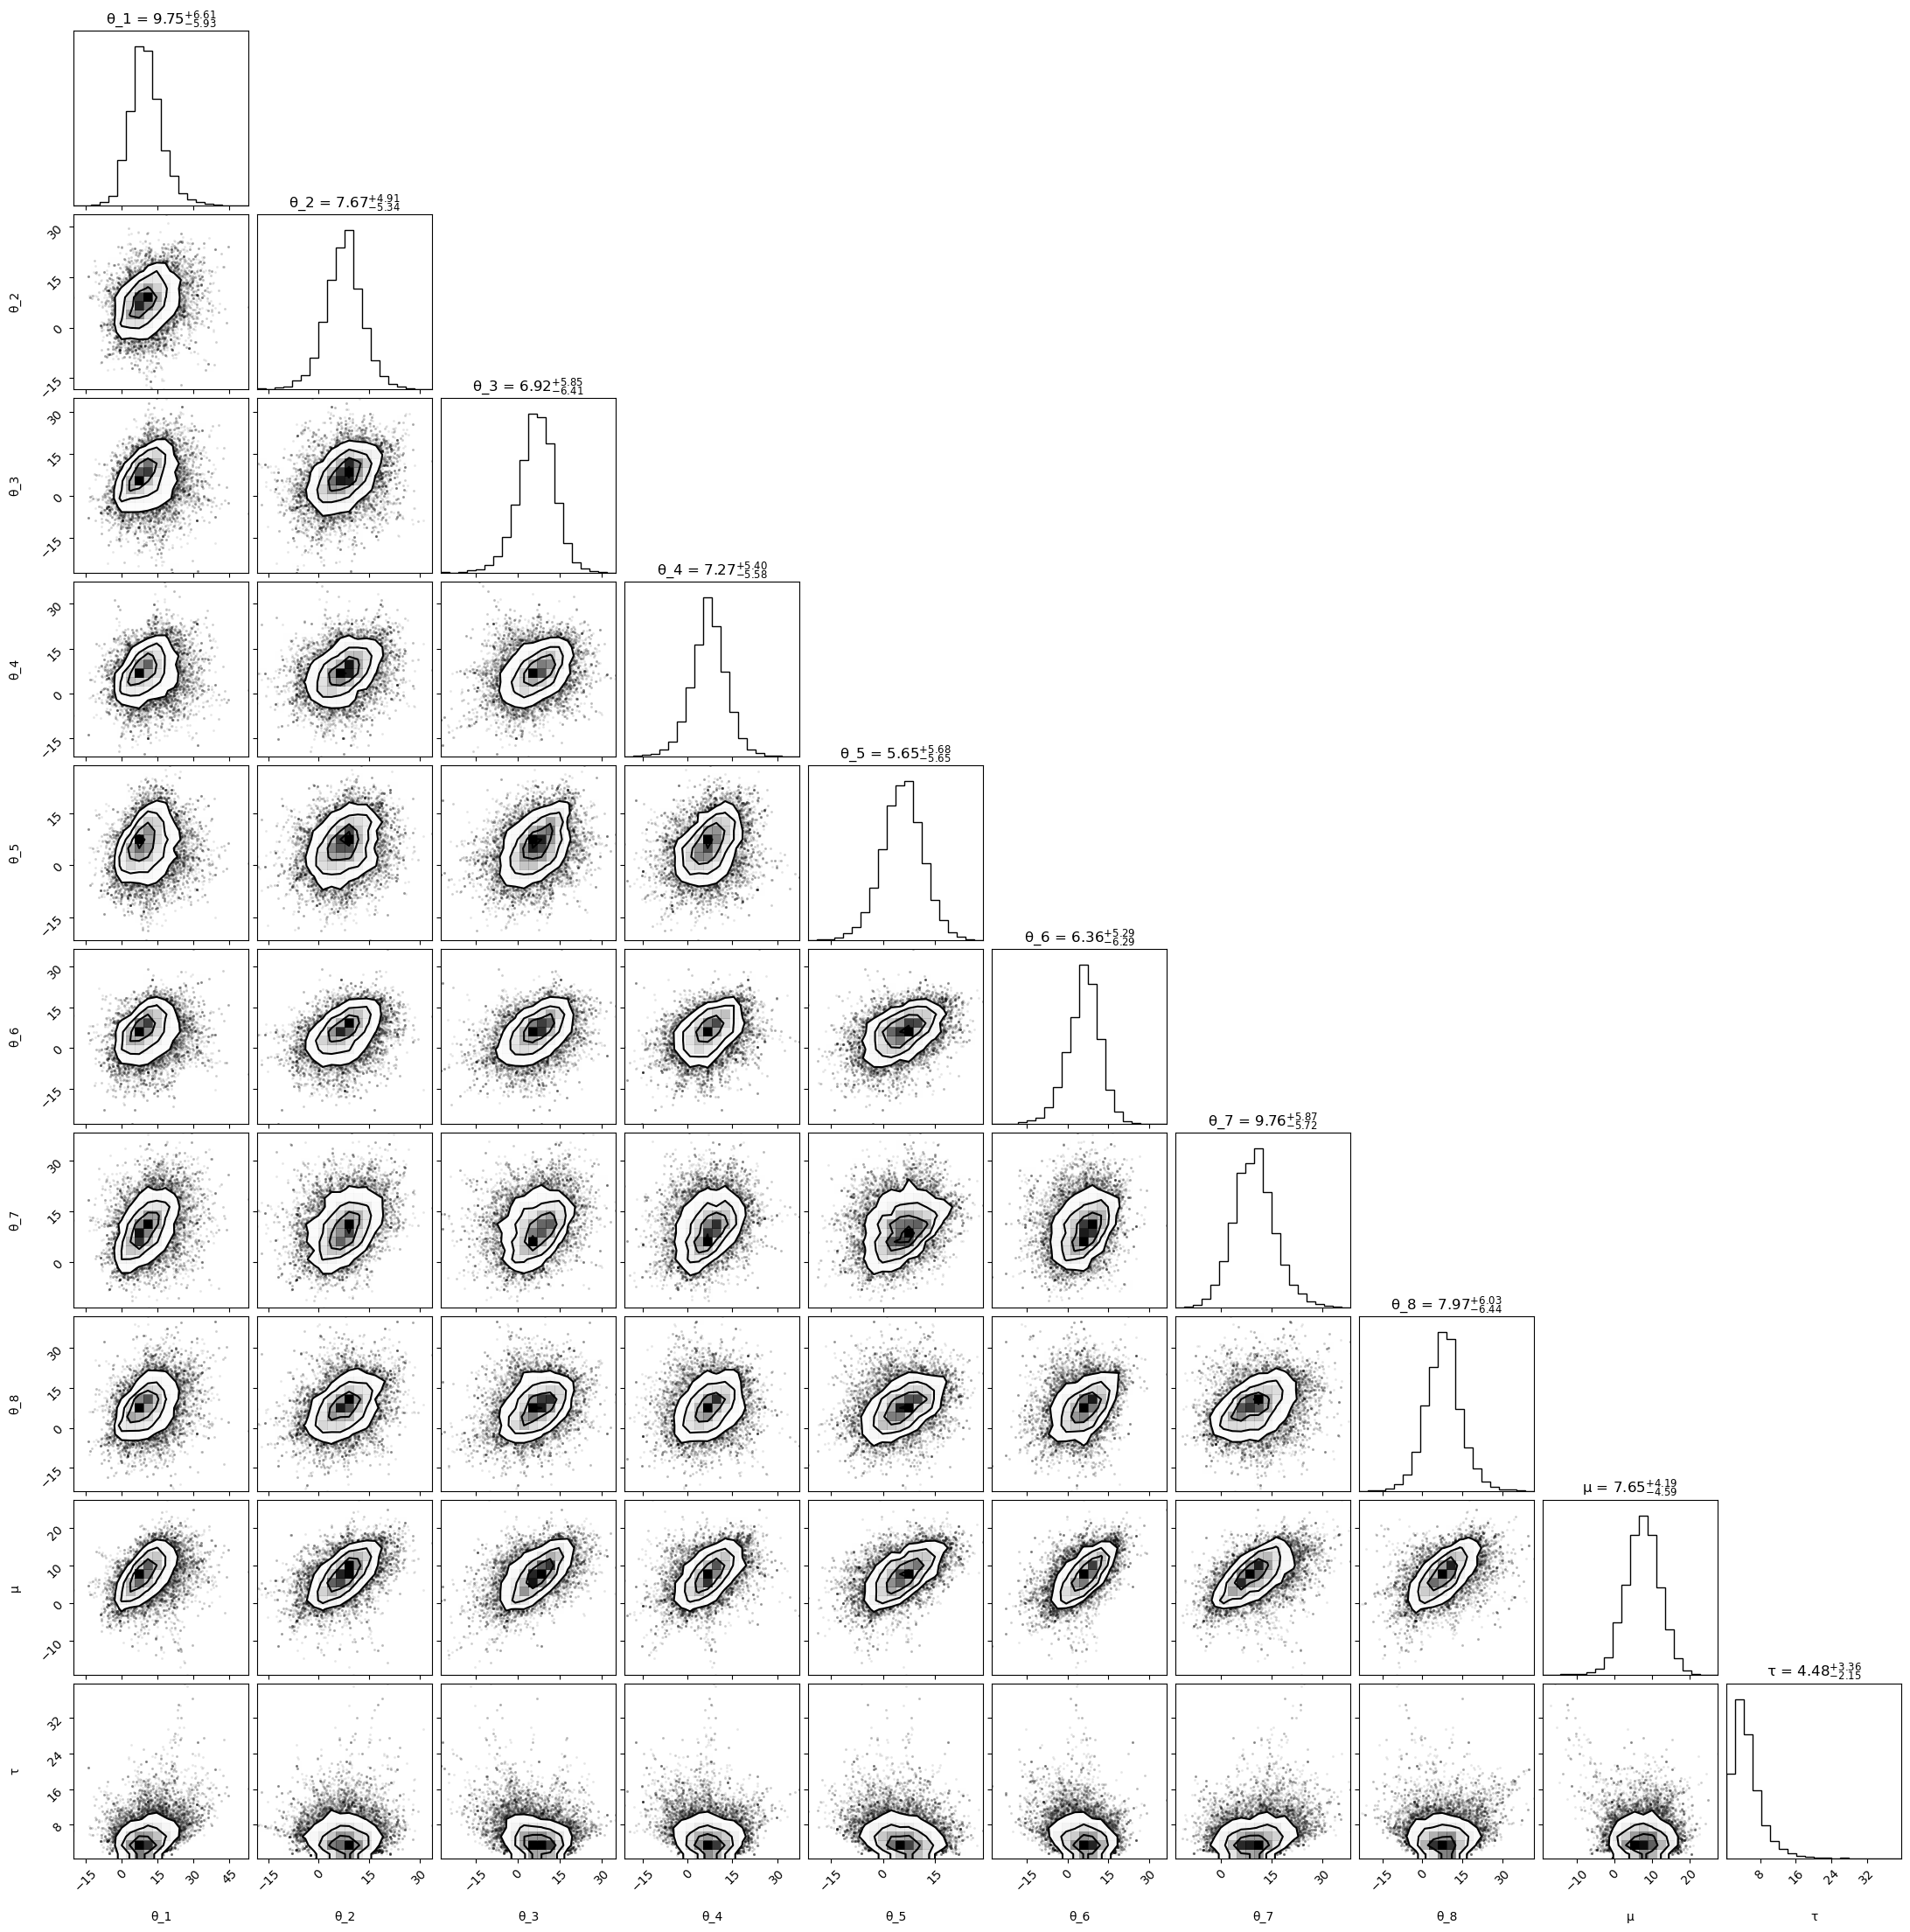

Parameter estimates (mean ± std):
θ_1: 10.25 ± 6.74
θ_2: 7.50 ± 5.52
θ_3: 6.69 ± 6.66
θ_4: 7.15 ± 5.85
θ_5: 5.59 ± 5.91
θ_6: 5.89 ± 6.11
θ_7: 9.90 ± 6.15
θ_8: 7.87 ± 6.75
μ: 7.55 ± 4.50
τ: 5.18 ± 3.37


In [13]:
import corner
import matplotlib.pyplot as plt
import numpy as np

# Remove burn-in and flatten
flat_samples = sampler.get_chain(discard=300, flat=True)

# Create corner plot for key parameters
# Focus on school effects and hyperparameters
labels = [f"θ_{i+1}" for i in range(8)] + ["μ", "τ"]
fig = corner.corner(flat_samples, labels=labels, 
                   truths=None, show_titles=True)
plt.show()

# Print summary statistics
print("Parameter estimates (mean ± std):")
for i, label in enumerate(labels):
    mean_val = np.mean(flat_samples[:, i])
    std_val = np.std(flat_samples[:, i])
    print(f"{label}: {mean_val:.2f} ± {std_val:.2f}")

# Problem 2: The Five Districts

The test-prep program was expanded across five districts, for a total of 27 schools. For each school, the mean score improvement, uncertainty on the mean, and number of hours each student spent studying was recorded.

### Exercises

a) Load the Five Districts dataset (five_districts.csv) and plot the data
b) Determine the expected score improvement per hour studied for each school using three different models:

+ i. A fully pooled model
+ ii. Independent estimates for each district
+ iii. A hierarchical model that asserts a relationship between the schools and districts.

For all three cases, sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

For the third option, draw the relationship as a directed acyclic graph. Justify your choices of distributions for parameters and hyper-parameters, and test your results for sensitivity to modeling choices.


# Problem 3: Dyson Spheres

Congratulations! You've detected a strange class of objects that you suspect are [Dyson spheres](https://en.wikipedia.org/wiki/Dyson_sphere). Your data are sparse, but you nonetheless detect hints of variability in each object's brightness.

a) Load the Dyson Sphere dataset (dyson_spheres.csv) and plot the time series data. What do you notice about the relative amplitude variations?

b) For each object, compute a Lomb-Scargle periodogram. What do you notice about the frequency-power plot?

c) Assume that each object's time series can be modeled as a single-component sinusoid. Construct a hierarchical model for the population, asserting some population-level relationship between the amplitudes, frequencies, and phases for each object's sinusoid. Which parameters might be expected to be correlated or independent of one another?

# Problem 4: Astrophysics

Select an astrophysical dataset of your choosing. Describe any hierarchical structure in the data using a directed acyclic graph. Build a simple hierarchical model for the data. You may wish to use only a few member objects of your dataset in order to more rapidly iterate while developing.